# ML Model 03: Bayesian Ridge Regression\n
\n
This notebook trains a **BayesianRidge** model on the same feature-extracted dataset and with the same asset-first split policy as Model 01/02.\n
\n
Bayesian ridge can be a useful baseline for linear models when you want L2-like regularization with uncertainty-aware parameter estimation.\n

In [4]:
import os
from dataclasses import dataclass

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [5]:
SEED = 42
FEATURES_PARQUET_PATH = '../dataset/features/all_features.parquet'
TARGET_COL = 'ret_1d'
TARGET_FWD_COL = 'y_ret_1d_fwd'

N_TRAIN_ASSETS = 75
N_VAL_ASSETS = 15

OUTPUT_DIR = 'dataset/model_outputs/linear_models_03_bayesianridge'
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [6]:
df = pd.read_parquet(FEATURES_PARQUET_PATH)
# Support both formats: Date as index (older) or Date as a column (CSV->Parquet conversion).
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
df = df.sort_index()
df = df.copy()
df[TARGET_FWD_COL] = df.groupby('Asset_ID', sort=False)[TARGET_COL].shift(-1)
df = df.dropna(subset=[TARGET_FWD_COL])

assets = sorted(df['Asset_ID'].unique())
train_assets = assets[:N_TRAIN_ASSETS]
val_assets = assets[N_TRAIN_ASSETS:N_TRAIN_ASSETS + N_VAL_ASSETS]
test_assets = assets[N_TRAIN_ASSETS + N_VAL_ASSETS:]

df_train = df[df['Asset_ID'].isin(train_assets)].copy()
df_val = df[df['Asset_ID'].isin(val_assets)].copy()
df_test = df[df['Asset_ID'].isin(test_assets)].copy()

exclude_cols = {'Asset_ID', TARGET_FWD_COL}
feature_cols = [c for c in df.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]

def to_xy(d: pd.DataFrame):
    X = d.loc[:, feature_cols].replace([np.inf, -np.inf], np.nan)
    y = d.loc[:, TARGET_FWD_COL]
    return X, y

X_train, y_train = to_xy(df_train)
X_val, y_val = to_xy(df_val)
X_test, y_test = to_xy(df_test)

print('assets train/val/test:', len(train_assets), len(val_assets), len(test_assets))
print('rows train/val/test:', X_train.shape[0], X_val.shape[0], X_test.shape[0])
print('n_features:', len(feature_cols))


assets train/val/test: 75 15 10
rows train/val/test: 188250 37650 25100
n_features: 121


In [7]:
@dataclass(frozen=True)
class RegressionMetrics:
    rmse: float
    mae: float
    r2: float
    spearman_ic: float


def compute_metrics(y_true: pd.Series, y_pred: np.ndarray) -> RegressionMetrics:
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    ic = float(spearmanr(y_true.to_numpy(), y_pred, nan_policy='omit').correlation)
    return RegressionMetrics(rmse=rmse, mae=mae, r2=r2, spearman_ic=ic)


In [8]:
bayes = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', BayesianRidge()),
    ]
)

bayes.fit(X_train, y_train)

print('train:', compute_metrics(y_train, bayes.predict(X_train)))
print('val  :', compute_metrics(y_val, bayes.predict(X_val)))
print('test :', compute_metrics(y_test, bayes.predict(X_test)))


train: RegressionMetrics(rmse=0.018737951132340166, mae=0.012309928754914884, r2=0.021896025545004694, spearman_ic=0.041135949433132306)
val  : RegressionMetrics(rmse=0.017880202072073838, mae=0.012035428479825874, r2=0.02423126607930104, spearman_ic=0.028560250345520642)
test : RegressionMetrics(rmse=0.019451682145398743, mae=0.012953607038840294, r2=0.021298945373713574, spearman_ic=0.03304878849319106)


In [9]:
def export_preds(frame: pd.DataFrame, pipe: Pipeline, name: str) -> str:
    X, y = to_xy(frame)
    out = pd.DataFrame({
        'Date': frame.index,
        'Asset_ID': frame['Asset_ID'].to_numpy(),
        'y_true': y.to_numpy(),
        'y_pred': pipe.predict(X),
    })
    out_path = os.path.join(OUTPUT_DIR, f'preds_{name}.parquet')
    out.to_parquet(out_path, index=False)
    return out_path

{'val': export_preds(df_val, bayes, 'bayesianridge_val'), 'test': export_preds(df_test, bayes, 'bayesianridge_test')}


{'val': 'dataset/model_outputs/linear_models_03_bayesianridge/preds_bayesianridge_val.parquet',
 'test': 'dataset/model_outputs/linear_models_03_bayesianridge/preds_bayesianridge_test.parquet'}

Loading BokehJS ...

,Linear Model (bayesianridge) - Original Style 1N
Start,2016-01-25 00:00:00
End,2026-01-16 00:00:00
Duration,3644 days 00:00:00
Initial Equity,1000000.0
Final Equity,4368653.278401
Equity Peak,4389013.583917
Total Return [%],336.865328
CAGR [%],15.955106
Volatility (ann) [%],19.759208
Sharpe,0.849282


,Linear Model (bayesianridge) - Original Style MPT
Start,2016-01-25 00:00:00
End,2026-01-16 00:00:00
Duration,3644 days 00:00:00
Initial Equity,1000000.0
Final Equity,4664993.083092
Equity Peak,4680526.570156
Total Return [%],366.499308
CAGR [%],16.721692
Volatility (ann) [%],19.441379
Sharpe,0.892932


Starting actor-based backtest (MPT weights)...


100%|██████████| 2511/2511 [01:42<00:00, 24.50it/s]


Actor backtest finished.


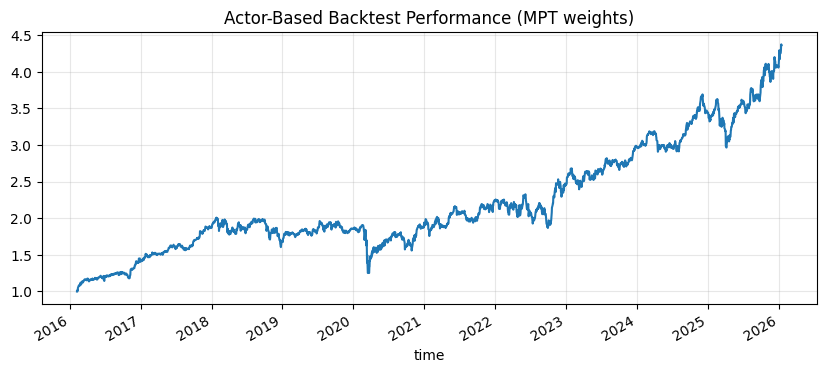

Actor Final Portfolio Value: 4361488.01326088
Actor Total Return [%]: 336.1488013260871


: 

In [ ]:
# --- Backtesting: Original Style (1N + MPT) and Actor-Based (MPT weights) ---
# Universe: held-out test assets only (asset-first split policy).

from pathlib import Path
import sys
import uuid

import numpy as np
import pandas as pd
from IPython.display import display

from bokeh.io import output_notebook, show
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, StaticPool

CWD = Path.cwd()
PROJECT_ROOT = CWD.parent if CWD.name == 'notebooks' else CWD
sys.path.append(str(PROJECT_ROOT))

from src.backtester.data import load_cleaned_assets, align_close_prices
from src.backtester.engine import BacktestConfig, run_backtest
from src.backtester.report import compute_backtest_report
from src.backtester.bokeh_plots import build_interactive_portfolio_layout
from src.backtester.portfolio import equal_weight, optimize_mpt

engine_root = (PROJECT_ROOT / 'another_testing_engine' / 'trade-engine' / 'trade-engine').resolve()
if str(engine_root) not in sys.path:
    sys.path.append(str(engine_root))
from tradeengine.actors.memory import MemPortfolioActor
from tradeengine.actors.sql import SQLOrderbookActor
from tradeengine.backtest import BacktestStrategy

final_model_name = 'bayesianridge'
final_pipe = bayes

pred_test = final_pipe.predict(X_test)
pred_long = pd.DataFrame({'Date': df_test.index, 'Asset_ID': df_test['Asset_ID'].to_numpy(), 'y_pred': pred_test})
pred_matrix = pred_long.pivot_table(index='Date', columns='Asset_ID', values='y_pred', aggfunc='mean').sort_index()

bt_assets = sorted(pred_matrix.columns.tolist())
assets_ohlcv = load_cleaned_assets(symbols=bt_assets, cleaned_dir=str(PROJECT_ROOT / 'dataset' / 'cleaned'))
close_prices = align_close_prices(assets_ohlcv)
pred_matrix = pred_matrix.reindex(close_prices.index)
returns_matrix = close_prices.pct_change().fillna(0.0)

market_df = pd.DataFrame({
    'Open': pd.concat([df['Open'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'High': pd.concat([df['High'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'Low': pd.concat([df['Low'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'Close': pd.concat([df['Close'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'Volume': pd.concat([df['Volume'] for df in assets_ohlcv.values()], axis=1).sum(axis=1),
}).sort_index()

output_notebook()

REBALANCE_FREQ = 'W'
TOP_K = min(20, len(bt_assets))
LOOKBACK_DAYS = 126

def build_weights_from_predictions(*, pm_style: str) -> pd.DataFrame:
    # Use last *trading day* of each rebalance period (not the period label like Sunday).
    rebal_dates = set(pd.Series(pred_matrix.index, index=pred_matrix.index).resample(REBALANCE_FREQ).last().dropna().tolist())
    w_last = pd.Series(0.0, index=bt_assets)
    w_rows = []
    for dt in pred_matrix.index:
        if dt in rebal_dates:
            row = pred_matrix.loc[dt].dropna().sort_values(ascending=False)
            top = row.head(TOP_K)
            candidates = [a for a, v in top.items() if np.isfinite(v) and v > 0]
            if len(candidates) == 0:
                w_last = pd.Series(0.0, index=bt_assets)
            else:
                if pm_style == '1N':
                    w_dict = equal_weight(candidates)
                elif pm_style == 'MPT':
                    w_dict = optimize_mpt(returns_matrix, candidates, dt, lookback_days=LOOKBACK_DAYS)
                else:
                    raise ValueError(f'Unknown pm_style: {pm_style!r}')
                w_last = pd.Series(0.0, index=bt_assets)
                for a, w in w_dict.items():
                    if a in w_last.index:
                        w_last[a] = float(w)
        w_rows.append(w_last)
    return pd.DataFrame(w_rows, index=pred_matrix.index, columns=bt_assets).fillna(0.0)

weights_1n = build_weights_from_predictions(pm_style='1N')
weights_mpt = build_weights_from_predictions(pm_style='MPT')

cfg_vec = BacktestConfig(initial_equity=1_000_000.0, transaction_cost_bps=5.0, mode='vectorized')

def run_and_report(weights: pd.DataFrame, title: str):
    res = run_backtest(close_prices, weights, config=cfg_vec)
    report = compute_backtest_report(result=res, close_prices=close_prices)
    display(report.to_frame(title))
    layout = build_interactive_portfolio_layout(
        market_ohlcv=market_df,
        equity=res.equity,
        returns=res.returns,
        weights=res.weights,
        turnover=res.turnover,
        costs=res.costs,
        close_prices=close_prices,
        title=title,
    )
    show(layout)
    return res, report

_res_1n, _rpt_1n = run_and_report(weights_1n, f'Linear Model ({final_model_name}) - Original Style 1N')
_res_mpt, _rpt_mpt = run_and_report(weights_mpt, f'Linear Model ({final_model_name}) - Original Style MPT')

def weights_to_formatted_signals(w: pd.DataFrame) -> dict[str, pd.Series]:
    # Convert to trading-day timestamps (actor engine requires timestamps to exist in market data index).
    rebal_dates = pd.Series(w.index, index=w.index).resample(REBALANCE_FREQ).last().dropna().tolist()
    active: set[str] = set()
    sig: dict[str, dict[pd.Timestamp, dict]] = {a: {} for a in w.columns}
    for dt in rebal_dates:
        if dt not in w.index:
            continue
        row = w.loc[dt]
        for a in list(active):
            if float(row.get(a, 0.0)) <= 0.0:
                sig[a][dt] = {'CloseOrder': {}}
                active.remove(a)
        for a, weight in row.items():
            if float(weight) > 0.0:
                sig[a][dt] = {'TargetWeightOrder': {'size': float(weight)}}
                active.add(str(a))
    formatted: dict[str, pd.Series] = {}
    for a, d in sig.items():
        if d:
            s = pd.Series(d)
            s.index = pd.to_datetime(s.index)
            formatted[a] = s.sort_index()
        else:
            formatted[a] = pd.Series(dtype=object)
    return formatted

formatted_signals = weights_to_formatted_signals(weights_mpt)
quote_frames = {a: assets_ohlcv[a][['Open', 'High', 'Low', 'Close']] for a in bt_assets}

fund_value = 1_000_000.0
portfolio_actor = MemPortfolioActor.start(funding=fund_value)
db_engine = create_engine('sqlite://', echo=False, connect_args={'check_same_thread': False}, poolclass=StaticPool)
orderbook_actor = SQLOrderbookActor.start(portfolio_actor, db_engine, strategy_id=str(uuid.uuid4()))

print('Starting actor-based backtest (MPT weights)...')
bt_strategy = BacktestStrategy(orderbook_actor, portfolio_actor, quote_frames)
actor_result = bt_strategy.run_backtest(formatted_signals)
print('Actor backtest finished.')

perf = actor_result.porfolio_performance
fig, ax = plt.subplots(figsize=(10, 4))
perf['performance'].plot(ax=ax, title='Actor-Based Backtest Performance (MPT weights)')
ax.grid(True, alpha=0.3)
plt.show()
print('Actor Final Portfolio Value:', float(perf['value'].iloc[-1]))
print('Actor Total Return [%]:', float((perf['performance'].iloc[-1] - 1) * 100.0))
